In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Load the subject's DataFrame
big_df = pd.read_csv(r"W:\Projects\2019-04 M1M1PAS Project\analysis\source_Paolo\fc_source\sourceConnectivityBeamformeroldLF.csv",index_col=0)

# Print the reshaped DataFrame
print(big_df)

        subject    task  run      wpli     ciplv       aec
0            11  negneg    1  0.797908  0.455430  0.358458
1            11  negneg    1  0.740365  0.392892  0.342111
2            11  negneg    1  0.732197  0.347736  0.420003
3            11  negneg    1  0.672993  0.307565  0.247104
4            11  negneg    1  0.615073  0.270595  0.254893
...         ...     ...  ...       ...       ...       ...
178791        9  random    5  0.153306  0.091197  0.194966
178792        9  random    5  0.098064  0.158850  0.288621
178793        9  random    5  0.674889  0.512338  0.195566
178794        9  random    5  0.730541  0.585693  0.244831
178795        9  random    5  0.958319  0.746651  0.271086

[178796 rows x 6 columns]


(array([42833., 60377., 36599., 19957., 10158.,  5098.,  2410.,   986.,
          312.,    66.]),
 array([7.45321889e-04, 9.40588884e-02, 1.87372455e-01, 2.80686021e-01,
        3.73999588e-01, 4.67313154e-01, 5.60626721e-01, 6.53940287e-01,
        7.47253854e-01, 8.40567420e-01, 9.33880987e-01]),
 <BarContainer object of 10 artists>)

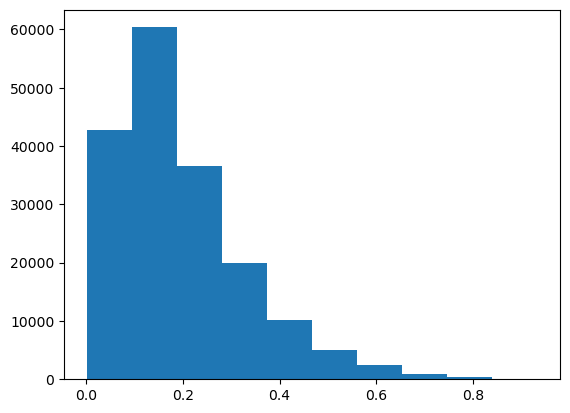

In [25]:
plt.hist(big_df.aec)

In [49]:
# Fix variable types and check for NaNs
big_df['run'] = big_df['run'].astype(str)
print(big_df.dtypes)
print(big_df.isna().sum())

subject      int64
task        object
run         object
wpli       float64
ciplv      float64
aec        float64
dtype: object
subject    0
task       0
run        0
wpli       0
ciplv      0
aec        0
dtype: int64


In [45]:
# Group by the desired columns and calculate median
con_mes = 'aec'

summary_df_ind = big_df.groupby(['run', 'task', 'subject'], as_index=False).agg(
    median_sub_connect=(con_mes, 'median'),
)
print(summary_df_ind)

     run    task  subject  median_sub_connect
0      1  negneg        1            0.199917
1      1  negneg        2            0.140417
2      1  negneg        3            0.178938
3      1  negneg        4            0.154797
4      1  negneg        5            0.140687
..   ...     ...      ...                 ...
314    5  random       13            0.143162
315    5  random       14            0.158709
316    5  random       15            0.159534
317    5  random       16            0.155209
318    5  random       17            0.174015

[319 rows x 4 columns]


In [46]:
# Function to calculate 25th and 75th percentiles
def q25(x):
    return np.percentile(x, 25)

def q75(x):
    return np.percentile(x, 75)

# Group by 'run', 'task' and calculate medians and quartiles
summary_df = summary_df_ind.groupby(['run', 'task']).agg(
    median_connect=('median_sub_connect', 'median'), 
    q1_connect=('median_sub_connect', q25),
    q3_connect=('median_sub_connect', q75)
).reset_index()

# Calculate the errors (distance between median and quartiles)
summary_df['lower_err'] = summary_df['median_connect'] - summary_df['q1_connect']
summary_df['upper_err'] = summary_df['q3_connect'] - summary_df['median_connect']

C:\Users\Maria\AppData\Local\Temp\ipykernel_19368\3662310191.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


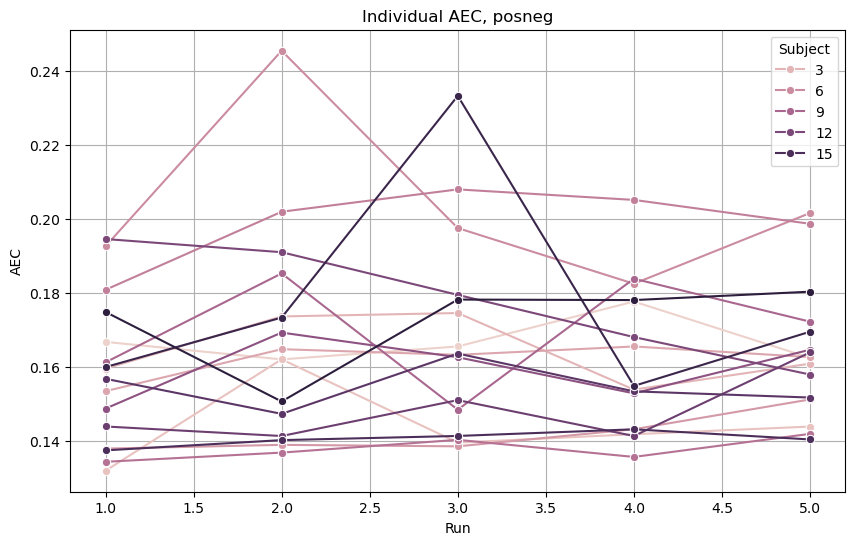

In [47]:
data_to_plot = summary_df_ind[summary_df_ind["task"] == "posneg"]

# Plot
plt.figure(figsize=(10, 6))

# Plot the median values using seaborn
sns.lineplot(
    data=data_to_plot, 
    x='run', 
    y='median_sub_connect', 
    hue='subject', 
    marker='o', 
    ci=None  # We will add custom error bars for quartiles
)

# Get the colors used by seaborn for each task line
palette = sns.color_palette()

# Customize the plot
plt.title("Individual AEC, posneg")
plt.xlabel("Run")
plt.ylabel("AEC")
plt.legend(title="Subject")
plt.grid(True)

# Show the plot
plt.show()

C:\Users\Maria\AppData\Local\Temp\ipykernel_19368\1691725892.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


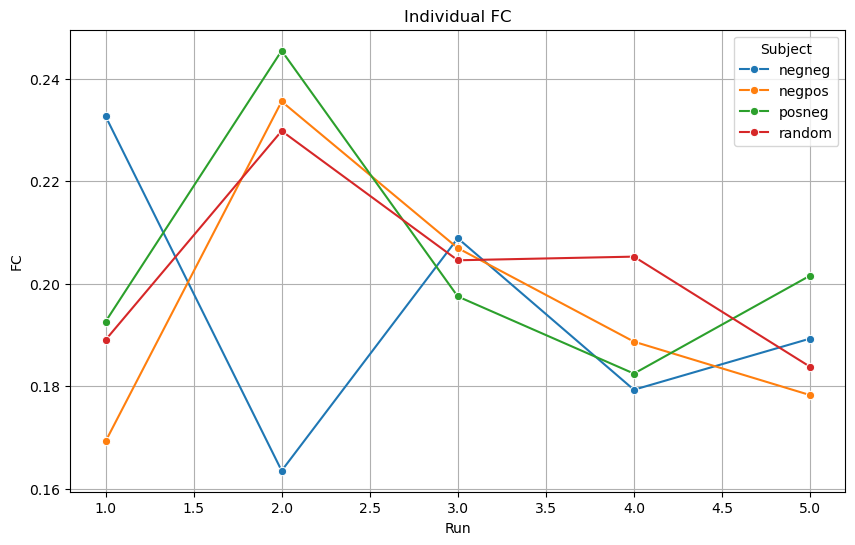

In [52]:
data_to_plot = summary_df_ind[summary_df_ind["subject"] == 6]

# Plot
plt.figure(figsize=(10, 6))

# Plot the median values using seaborn
sns.lineplot(
    data=data_to_plot, 
    x='run', 
    y='median_sub_connect', 
    hue='task', 
    marker='o', 
    ci=None  # We will add custom error bars for quartiles
)

# Get the colors used by seaborn for each task line
palette = sns.color_palette()

# Customize the plot
plt.title("Individual FC")
plt.xlabel("Run")
plt.ylabel("FC")
plt.legend(title="Subject")
plt.grid(True)

# Show the plot
plt.show()

C:\Users\Maria\AppData\Local\Temp\ipykernel_19368\1650820641.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


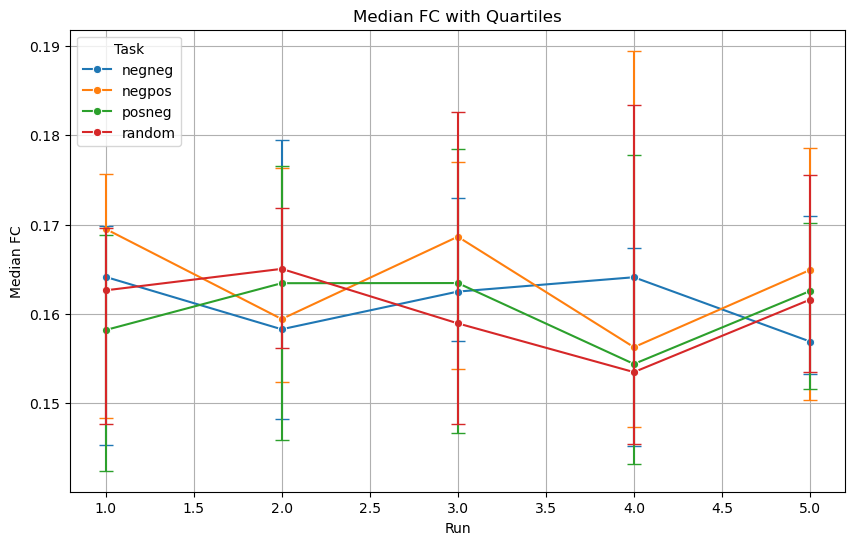

In [48]:
data_to_plot = summary_df

# Plot
plt.figure(figsize=(10, 6))

# Plot the median values using seaborn
sns.lineplot(
    data=data_to_plot, 
    x='run', 
    y='median_connect', 
    hue='task', 
    marker='o', 
    ci=None  # We will add custom error bars for quartiles
)

# Get the colors used by seaborn for each task line
palette = sns.color_palette()

# Add custom error bars for the quartiles with the same colors as the lines
for i, task in enumerate(data_to_plot['task'].unique()):
    task_data = data_to_plot[data_to_plot['task'] == task]
    plt.errorbar(
        task_data['run'], 
        task_data['median_connect'], 
        yerr=[task_data['lower_err'], task_data['upper_err']], 
        fmt='none',  # No line, just error bars
        capsize=5,  # Optional: adds caps to the error bars
        color=palette[i],  # Apply the same color as the line
    )

# Customize the plot
plt.title("Median FC with Quartiles")
plt.xlabel("Run")
plt.ylabel("Median FC")
plt.legend(title="Task")
plt.grid(True)

# Show the plot
plt.show()

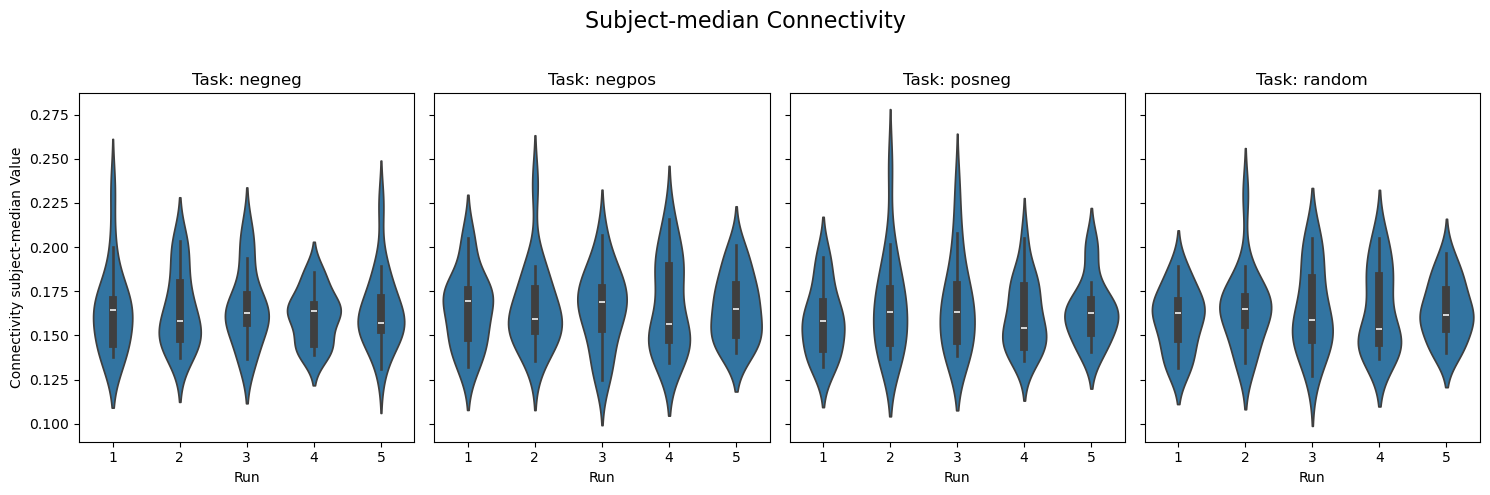

In [44]:
# Get the unique tasks for this subject
tasks = summary_df_ind['task'].unique()
    
# Create a figure with subplots for each task
fig, axes = plt.subplots(nrows=1, ncols=len(tasks), figsize=(15, 5), sharey=True)
fig.suptitle(f'Subject-median Connectivity', fontsize=16)

    
# Iterate through tasks and create a violin plot for each
for i, task in enumerate(tasks):
    task_df = summary_df_ind[summary_df_ind['task'] == task]
    sns.violinplot(ax=axes[i], x='run', y='median_sub_connect', data=task_df)
    axes[i].set_title(f'Task: {task}')
    axes[i].set_xlabel('Run')
    axes[i].set_ylabel('Connectivity subject-median Value')

# Show the plot for this subject
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()